In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.special import exp1, expi
from scipy import stats
from scipy import integrate
from scipy.interpolate import interp1d
from tqdm import tqdm

import viz 
# use the style file
plt.style.use('style.mpl')

colors = viz.color_palette()

LAMBDA_14C = 1/8267.0

In [2]:
C14_DATA_PATH = '../data/14C_atm_annot.csv'
C14_DATA = pd.read_csv(C14_DATA_PATH)

INTERP_R_14C = interp1d(C14_DATA.years_before_2000, C14_DATA.R_14C,
                        kind='zero', fill_value='extrapolate')

In [3]:
class PowerLawSimulation:
    def __init__(self, t_min, t_max):
        self.t_min = t_min
        self.t_max = t_max

        self.g_ts = None
        self.ts = None
        self.G_t = None
        self.interp_14c = interp1d(
            C14_DATA.years_before_2000, C14_DATA.R_14C,
            kind='zero', fill_value='extrapolate')

    def turnover_time(self):
        """Calculate the mean turnover time of the system."""
        # calculate the exponential integral E1(t_min/t_max) 
        E1_term = exp1(self.t_min / self.t_max)
        return self.t_min * np.exp(self.t_min / self.t_max) * E1_term
    
    def survival_fn(self, ages):
        """Define a power-law survival function.
        
        Parameters:
            ages (array-like): Array of ages.
        """
        float_ages = ages.astype(np.float64)
        num = self.t_min*np.exp(-float_ages/self.t_max)
        denom = float_ages + self.t_min
        return num / denom
    
    def age_distribution_pdf_analytic_ss(self, ages):
        """Calculate the age distribution function.
        
        Parameters:
            ages (array-like): Array of ages.
        """
        s = self.survival_fn(ages)
        return s / self.turnover_time()

    def age_distribution_cdf_analytic_ss(self, ages):
        """Calculate the cumulative distribution of
        the steady-state age distribution.

        Integral of PDF was calculated in Mathematica.

        CDF(ages) = (e^(tmin/tmax) tmin (E1(tmin/tmax) + E1((tmin + ages)/tmax)))/T

        Parameters:
            ages (array-like): Array of ages.
        """
        tmin, tmax = self.t_min, self.t_max
        T = self.turnover_time()
        Ei_term = expi(- tmin / tmax) - expi( -(tmin + ages)/tmax)
        return - np.exp(tmin/tmax) * tmin * Ei_term / T

    def radiocarbon_age_integrand(self, a):
        # Interpolation was done with x as years before present,
        # so a is the correct input here
        initial_r = self.interp_14c(a) 
        radiocarbon_decay = np.exp(-LAMBDA_14C*a)
        E1_term = exp1(self.t_min / self.t_max)
        age_dist_term = np.power((E1_term * (self.t_min + a)), -1) * np.exp(-(self.t_min + a)/self.t_max)
        return initial_r * age_dist_term * radiocarbon_decay
    
    def radiocarbon_ratio_ss(self):
        """Calculate the steady-state radiocarbon ratio."""
        integral, _ = integrate.quad(
            self.radiocarbon_age_integrand, 0, np.inf,
            limit=1500, epsabs=1e-3)
        return integral
        
    def run(self, inputs):
        """Run the simulation over the specified time steps.

        Note: assumes inputs occur at each time step, so that 
        the timesteps = np.arange(len(inputs)).

        Stores state in this object.

        Parameters:
            inputs (array-like): Input values at each time step.
        """
        n_time_steps = len(inputs)
        ts = np.arange(n_time_steps)

        # g_ts contains the decayed inputs over time
        # each row is an input at time t=i
        # each column is the amount remaining at time t+age        
        g_ts = np.zeros((n_time_steps, n_time_steps))

        g_ts = np.zeros((len(inputs), len(ts)+len(inputs) + 10))
        for i in range(n_time_steps):
            decay_i = inputs[i]*self.survival_fn(np.arange(n_time_steps))
            g_ts[i, i:i+len(decay_i)] = decay_i
            
        self.g_ts = g_ts.copy()
        self.ts = ts
        self.G_t = np.sum(self.g_ts, axis=0)

        return g_ts, ts

In [4]:
class LogNormalSimulation:
    def __init__(self, mu, sigma):
        """Initialize the log-normal simulation.
        
        Args:
            mu (float): Mean of the underlying normal distribution.
            sigma (float): Standard deviation of the underlying normal distribution.
        """
        self.mu = mu
        self.sigma = sigma

        self.g_ts = None
        self.ts = None
        self.G_t = None

    @classmethod
    def lognormal_integrand(cls, k, mu, sigma):
        """Integrand for the log-normal survival function."""
        p_k = stats.lognorm.pdf(k, s=sigma, scale=np.exp(mu))
        return np.exp(-k) * p_k

    def survival_fn(self, ages):
        """Define a log-normal survival function.

        survival function is the integral of exp(-k) p(k) dk from k=0 to current age
        where p(k) is the log-normal probability density function.
        
        Parameters:
            ages (array-like): Array of ages.
        """
        # do finer age-stepping than requested for better integral approximation
        n = len(ages)*10
        fine_ages = np.linspace(0, np.max(ages), num=n)

        # calculate the log-normal probability density function
        p_k = stats.lognorm.pdf(fine_ages, s=self.sigma, scale=np.exp(self.mu))

        # integrate exp(-k) * p(k) dk from k=0
        def integrand(k, mu, sigma):
            return np.exp(-k) * stats.lognorm.pdf(k, s=sigma, scale=np.exp(mu))
        integrate.quad(integrand, 0, ages[-1], args=(self.mu, self.sigma))
    
    def run(self, inputs):
        """Run the simulation over the specified time steps.

        Note: assumes inputs occur at each time step, so that 
        the timesteps = np.arange(len(inputs)).

        Stores state in this object.

        Parameters:
            inputs (array-like): Input values at each time step.
        """
        n_time_steps = len(inputs)
        ts = np.arange(n_time_steps)

        # g_ts contains the decayed inputs over time
        # each row is an input at time t=i
        # each column is the amount remaining at time t+age        
        g_ts = np.zeros((n_time_steps, n_time_steps))

        g_ts = np.zeros((len(inputs), len(ts)+len(inputs) + 10))
        for i in range(n_time_steps):
            decay_i = inputs[i]*self.survival_fn(np.arange(n_time_steps))
            g_ts[i, i:i+len(decay_i)] = decay_i
            
        self.g_ts = g_ts.copy()
        self.ts = ts
        self.G_t = np.sum(self.g_ts, axis=0)

        return g_ts, ts

In [5]:
models = [
    PowerLawSimulation(t_min=1, t_max=1000),
    PowerLawSimulation(t_min=10, t_max=500),
    PowerLawSimulation(t_min=50, t_max=10000),
]

# inputs are a train of impulses J_t 
# that are normally distributed with mean 10 and sd 2
np.random.seed(1234)
J_t = np.random.normal(10, 2, 5000)

for m in models:
    m.run(J_t)

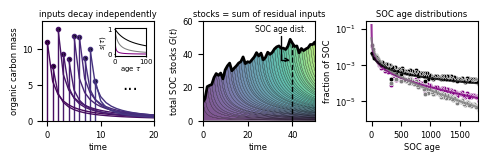

In [6]:
mosaic = 'ABC'
fig, axs = plt.subplot_mosaic(mosaic, layout='constrained', figsize=(4.76, 1.5))
# Most of the plot is about the first model
focal_model = models[0]
model_colors = ['purple', 'grey', 'k']
ages = np.arange(2000)

plt.sca(axs['A'])

# make a color palette with 20 colors
color_order = sns.color_palette("viridis", 60)

# plot the first 10 inputs
for i, (J, color) in enumerate(zip(J_t[:10], color_order[:10])):
    markerline, stemlines, baseline = plt.stem(
        i, J, color)
    markerline.set_markerfacecolor('k')
    markerline.set_markersize(3)
    stemlines.set_linewidth(1)

# g_ts contains the decayed inputs over time
# each row is an input at time t=i
# each column is the amount remaining at time t+age
g_ts = np.zeros((len(J_t), len(ages)+len(J_t) + 10))
for i in range(len(J_t)):
    decay_i = J_t[i]*focal_model.survival_fn(ages)
    g_ts[i, i:i+len(decay_i)] = decay_i

    # plot the first 10 only 
    if i >= 10:
        continue
    plt.plot(ages + i, decay_i, color=color_order[i], lw=1)

plt.xlabel('time')
plt.ylabel('organic carbon mass')
plt.text(15.5, 5, '...', fontsize=12, ha='center', va='center')
plt.xlim(-1, 20)
plt.ylim(0, 14)
plt.title('inputs decay independently')

# Make an inset axis on the top right of A
inset_ax = axs['A'].inset_axes([0.65, 0.65, 0.28, 0.28])
# Plot a some survival function for each model
for my_model, color_name in zip(models, model_colors):
    survival_fn = my_model.survival_fn(ages)
    inset_ax.plot(ages, survival_fn, 
                  color=color_name, lw=0.75)
inset_ax.set_xlim(0, 100)
inset_ax.set_xlabel(r'age $\tau$', fontsize=5, labelpad=0)
inset_ax.set_ylabel(r'$s(\tau)$', fontsize=5, labelpad=0)
inset_ax.tick_params(axis='both', which='major', labelsize=5, length=1, pad=1)

# plot the stocks over time, which is the sum of 
# what remains from prior inputs
plt.sca(axs['B'])

nts = g_ts.shape[1]
njs = g_ts.shape[0]
bottom = np.zeros(nts)
ts = np.arange(nts)
for i in range(njs):
    color = color_order[i % len(color_order)]
    top = bottom + g_ts[i, :]
    plt.fill_between(ts, bottom, top, color=color, alpha=0.7, 
                     edgecolor='k', lw=0.2)
    bottom = top

G_t = np.sum(g_ts, axis=0)
plt.plot(ts, G_t, color='black', lw=2)

# make a vertical dashed line at time = 45
my_t = 40
ymax = G_t[my_t]
plt.plot([my_t, my_t], [0, ymax], color='k', linestyle='--', lw=1)
# annotate the line with a curved arrow
arrowprops=dict(arrowstyle='->', connectionstyle='angle', lw=1)
plt.annotate('SOC age dist.', xy=(my_t, ymax-10), xytext=(my_t - 5, ymax + 7),
             arrowprops=arrowprops, fontsize=5.5, ha='center',
             bbox=dict(boxstyle='square,pad=0.0', edgecolor='none', facecolor='None'))

plt.xlabel('time')
plt.xlim(0, 50)
plt.ylim(0, 60)
plt.ylabel(r'total SOC stocks $G(t)$')
plt.title(r'stocks = sum of residual inputs')

plt.sca(axs['C'])
plt.yscale('log')

for model, color_name in zip(models, model_colors):
    analytical_age_dist = model.age_distribution_pdf_analytic_ss(ages)
    plt.plot(ages, analytical_age_dist, color=color_name, lw=1.5, alpha=0.8, 
             label=f'$t_min=${model.t_min}, $t_max=${model.t_max}')
    
    # simulated age distribution at time my_t
    my_t = 2000
    simulated_ages = my_t - model.ts
    simulated_stocks = model.g_ts[:, my_t] / np.sum(model.g_ts[:, my_t])
    # remove negative ages and normalize
    SOC_ages = simulated_ages[:my_t]
    stocks = simulated_stocks[:my_t]
    normalized_stocks = stocks / np.sum(stocks)

    # Plot a subset of points to avoid too much overlap
    max_age = min(2000, len(SOC_ages)) # limit to 2000
    idxs = list(np.arange(50)) + list(np.arange(50, max_age, 15))
    plt.scatter(SOC_ages[idxs], normalized_stocks[idxs],
                color=color_name, s=11, edgecolor='w', linewidth=0.4)
    
#plt.legend()
xmin, _ = plt.xlim()
plt.xlim(xmin, 1800)
plt.xticks([0, 500, 1000, 1500])
plt.xlabel('SOC age')
plt.ylabel('fraction of SOC')
plt.title('SOC age distributions')

plt.savefig('../figures/fig1.png', dpi=300, bbox_inches='tight')
plt.show()

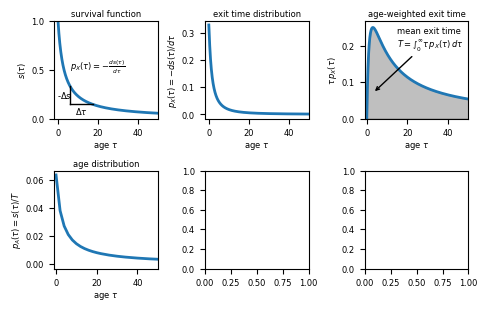

In [7]:
# Use a slower decaying power-law for the next figure
my_sim = PowerLawSimulation(t_min=3, t_max=1000)
my_sim.run(J_t)

mosaic = "ABC\nDEF"
fig, axs = plt.subplot_mosaic(mosaic, layout='constrained',
                              figsize=(4.76, 3))

# Panel A plot the survival function
plt.sca(axs['A'])
ages = np.linspace(0, 50, 1000)
plt.plot(ages, my_sim.survival_fn(ages))

# mark two timepoints on the curve with dashed lines
idx_0, idx_1 = 120, 350
age_0, age_1 = ages[idx_0], ages[idx_1]
s_0, s_1 = my_sim.survival_fn(np.array([age_0, age_1]))

# Label the area as the amount exiting after age_0 and before age_1
midpoint_age = (age_0 + age_1) / 2
midpoint_s = np.mean([s_0, s_1])

plt.plot([age_0, age_0], [s_1, s_0], color='k', linestyle='-', lw=1)
plt.plot([age_0, age_1], [s_1, s_1], color='k', linestyle='-', lw=1)
plt.text(s_0 - 1, midpoint_s, r'-$\Delta s$',
         va='center', ha='left', fontsize=6)
plt.text(midpoint_age, 0.08, r'$\Delta \tau$',
         fontsize=6, ha='center', va='center')
plt.text(20, 0.5, r'$p_X(\tau) = -\frac{ds(\tau)}{d\tau}$',
         ha='center', fontsize=6)

plt.ylabel(r'$s(\tau)$')
plt.xlabel(r'age $\tau$')
plt.title('survival function')
plt.ylim(0, 1)
plt.yticks([0, 0.5, 1])
plt.xlim(-2, 50)

# Panel B plot the exit time distribution p_X(tau) = -ds/dtau
plt.sca(axs['B'])
ages = np.linspace(0, 50, 1000)
ds_dtau = -np.gradient(my_sim.survival_fn(ages), ages)
plt.plot(ages, ds_dtau)

plt.ylabel(r'$p_X(\tau) = -ds(\tau)/d\tau$')
plt.xlabel(r'age $\tau$')
plt.title('exit time distribution')
#plt.ylim(0, 1)
#plt.yticks([0, 0.5, 1])
plt.xlim(-2, 50)

# Panel C plot tau*p_X(tau)
plt.sca(axs['C'])
ages = np.linspace(0, 50, 1000)
ds_dtau = -np.gradient(my_sim.survival_fn(ages), ages)
tau_px = ages * ds_dtau
plt.plot(ages, tau_px)

# shade an area
plt.fill_between(ages, 0, tau_px, where=(ages <= 50),
                 color='grey', alpha=0.5)

# label the area as the mean exit time
annotation = ('mean exit time\n'
              r'$T = \int_0^\infty \tau \, p_X(\tau) \, d\tau$')
plt.annotate(annotation, xy=(3, 0.07), xytext=(15, 0.2),
             arrowprops=dict(arrowstyle='->', lw=1))
#plt.text(25, 5, 'mean exit time', fontsize=6, ha='center', va='center')

plt.ylabel(r'$\tau \, p_X(\tau)$')
plt.xlabel(r'age $\tau$')
plt.title(r'age-weighted exit time')
plt.xlim(-1, 50)
plt.ylim(0, 0.27)
plt.yticks([0, 0.1, 0.2])

# plot the age distribution at SS which is s(tau)/T
plt.sca(axs['D'])
ages = np.linspace(0, 2000, 1000)
s_tau = my_sim.survival_fn(ages)
T = my_sim.turnover_time()
p_A_tau = s_tau / T
plt.plot(ages, p_A_tau)
plt.ylabel(r'$p_A(\tau) = s(\tau)/T$')
plt.xlabel(r'age $\tau$')
plt.title('age distribution')
plt.xlim(-1, 50)

plt.savefig('../figures/fig_2_age_v_transit.png', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
models = [
    PowerLawSimulation(t_min=1, t_max=1000),
    PowerLawSimulation(t_min=10, t_max=500),
    PowerLawSimulation(t_min=50, t_max=10000),
]

# inputs are a train of impulses J_t 
# that are normally distributed with mean 10 and sd 2
np.random.seed(1234)
J_t = np.random.normal(10, 2, 5000)

for m in models:
    m.run(J_t)

(-2.0, 1800.0)

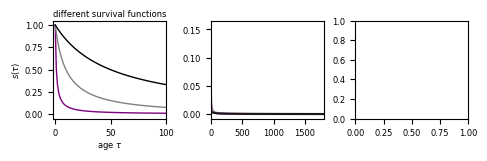

In [9]:
mosaic = 'ABC'
fig, axs = plt.subplot_mosaic(mosaic, layout='constrained', figsize=(4.76, 1.5))

# Panel A -- 3 different survival functions
plt.sca(axs['A'])
ages = np.arange(2000)
model_colors = ['purple', 'grey', 'k']
for my_model, color_name in zip(models, model_colors):  
    survival_fn = my_model.survival_fn(ages)
    plt.plot(ages, survival_fn, 
              color=color_name, lw=1,
             label=f'$t_{{min}}={my_model.t_min}$, $t_{{max}}={my_model.t_max}$')
plt.xlim(-2, 100)
plt.xlabel(r'age $\tau$')
plt.ylabel(r'$s(\tau)$')
plt.title('different survival functions')

# Panel B -- different steady-state age distributions
plt.sca(axs['B'])
ages = np.arange(2000)
for my_model, color_name in zip(models, model_colors):
    analytical_age_dist = my_model.age_distribution_pdf_analytic_ss(ages)
    plt.plot(ages, analytical_age_dist, 
              color=color_name, lw=1.5, alpha=0.8,
             label=f'$t_{{min}}={my_model.t_min}$, $t_{{max}}={my_model.t_max}$')
plt.xlim(-2, 1800)


In [10]:
def calc_survival(mu, sigma, ln_ks, ts):
    k_amts = stats.norm.pdf(ln_ks, loc=mu, scale=sigma)
    ks = np.exp(ln_ks)
    k_amts_normed = k_amts / np.sum(k_amts)

    M = np.zeros((len(ks), len(ts)))
    for j, t in enumerate(ts):
        exponent = -ks * t
        exponential_prefactor = np.exp(exponent)
        frac_remaining = exponential_prefactor * k_amts_normed
        M[:, j] = frac_remaining

    # survival function is the sum over all k of M
    return M

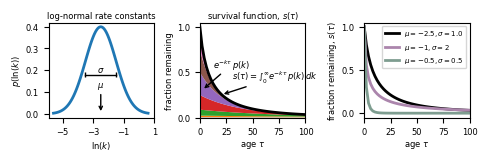

In [11]:
mosaic = 'ABC'
fig, axs = plt.subplot_mosaic(mosaic, layout='constrained', figsize=(4.76, 1.5))

# if Y ~ normal(mu, sigma) then X = exp(Y) ~ lognormal(mu, sigma)
mu = -2.5
sigma = 1

# plot the pdf with a logarithmic x-axis
plt.sca(axs['A'])

# plot the pdf
qs = [0.001, 0.5, 0.999]
qvals = stats.norm.ppf(qs, loc=mu, scale=sigma)
ln_k_s = np.linspace(qvals[0], qvals[-1], 100)
p_ln_ks = stats.norm.pdf(ln_k_s, loc=mu, scale=sigma)

plt.plot(ln_k_s, p_ln_ks)

plt.annotate(r'$\mu$', xy=(mu, 0.0), xytext=(mu, 0.12),
             ha='center',
             bbox=dict(boxstyle='round,pad=0.01', edgecolor='none', facecolor='None'),
             arrowprops=dict(arrowstyle='->', lw=1))
plt.text(mu, 0.2, r'$\sigma$', ha='center', va='center', fontsize=6)
plt.plot([mu-sigma, mu + sigma], [0.18, 0.18], color='k', lw=1)
plt.vlines([mu - sigma, mu + sigma], ymin=0.17, ymax=0.19, color='k', lw=1)

plt.xlabel(r'$\ln(k)$')
plt.ylabel(r'$p(\ln(k))$')
plt.xticks(np.arange(-5, 1.1, 2))
plt.title('log-normal rate constants')

plt.sca(axs['B'])
# sample 100 bins from normal(mu, sigma)
ln_k_s = np.linspace(mu - 3*sigma, mu + 3*sigma, 10)
ks = np.exp(ln_k_s)
k_amts = stats.norm.pdf(ln_k_s, loc=mu, scale=sigma)
k_amts_normed = k_amts / np.sum(k_amts)

ts = np.linspace(0, 100, 50)
M = calc_survival(mu, sigma, ln_k_s, ts)

plt.stackplot(ts, M)
# annotate single slice as e^-kt*p(k)*J_0
plt.annotate(r'$e^{-k \tau} \, p(k)$',
             xy=(2, 0.3), xytext=(12, 0.5),
             ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.01', edgecolor='none', facecolor='None'),
             arrowprops=dict(arrowstyle='->', lw=1))
plt.annotate(r'$s(\tau) = \int_0^\infty e^{-k \tau} \, p(k) \, dk$',
             xy=(20, 0.25), xytext=(30, 0.35),
             ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.01', edgecolor='none', facecolor='None'),
             arrowprops=dict(arrowstyle='->', lw=1))

# survival function is the sum over all k of M
survival_function = np.sum(M, axis=0)
plt.plot(ts, survival_function, color='k', lw=2)
plt.xlim(0, 100)
plt.title(r'survival function, $s(\tau)$')
plt.xlabel(r'age $\tau$')
plt.ylabel(r'fraction remaining')
plt.yticks(np.arange(0, 1.1, 0.5))

plt.sca(axs['C'])

mus = [-2.5, -1, -0.5]
sigmas = [1.0, 2, 0.5]
my_colors = ['k', colors['purple'], colors['dark_green']]

for mu, sigma, color in zip(mus, sigmas, my_colors):
    M = calc_survival(mu, sigma, ln_k_s, ts)
    plt.plot(ts, np.sum(M, axis=0), label=f'$\mu={mu}, \sigma={sigma}$', color=color)
plt.xlim(0, 100)
plt.yticks(np.arange(0, 1.1, 0.5))
plt.ylabel(r'fraction remaining, $s(\tau)$')
plt.xlabel(r'age $\tau$')
plt.legend(loc='upper right')

plt.savefig('../figures/fig2_lognormal_example.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Exemplify calibration of the power-law model.
# vary t_min and t_max and calculate the turnover T and
# steady-state radiocarbon ratio. Store these in matrices
# and plot as contour plots.
t_min_values = np.linspace(0.1, 10, 100)
t_max_values = np.linspace(1000, 100000, 100)
t_min_grid, t_max_grid = np.meshgrid(
    t_min_values, t_max_values, indexing='ij')

T_matrix = np.zeros((len(t_min_values), len(t_max_values)))
R_14C_matrix = np.zeros((len(t_min_values), len(t_max_values)))

for i, t_min in enumerate(tqdm(t_min_values, desc='t_min loop')):
    for j, t_max in enumerate(tqdm(t_max_values, desc='t_max loop', leave=False)):
        my_model = PowerLawSimulation(t_min=t_min, t_max=t_max)
        T_matrix[i, j] = my_model.turnover_time()
        R_14C_matrix[i, j] = my_model.radiocarbon_ratio_ss()

t_min loop: 100%|██████████| 100/100 [03:45<00:00,  2.26s/it]


In [18]:
target_Ts = [1, 3, 10, 50]
target_R_14Cs = [1.1, 1., 0.88, 0.78]
calibrated_Ts = []
calibrated_R_14Cs = []
calibrated_models = []

for target_T, target_R_14C in zip(target_Ts, target_R_14Cs):
    # find positions where T = target_T and R_14C = target_R_14C
    T_positions = np.argwhere(np.isclose(T_matrix, target_T, rtol=0.1))
    R_14C_positions = np.argwhere(np.isclose(R_14C_matrix, target_R_14C, rtol=0.1))

    pct_diffs_T = 100 * (T_matrix - target_T) / target_T
    pct_diffs_R_14C = 100 * (R_14C_matrix - target_R_14C) / target_R_14C
    loss_mat = (pct_diffs_T**2 + pct_diffs_R_14C**2)
    min_idx = np.unravel_index(np.argmin(loss_mat), loss_mat.shape)

    print(f'For target T={target_T}, R_14C={target_R_14C}:')
    print(f'Calibrated parameters: t_min = {t_min_values[min_idx[0]]}, t_max = {t_max_values[min_idx[1]]}')
    print(f'With Turnover Time = {T_matrix[min_idx]}, R_14C = {R_14C_matrix[min_idx]}')
    print(f'Percent differences: dT/T = {pct_diffs_T[min_idx]}, dR_14C/R_14C = {pct_diffs_R_14C[min_idx]}')
    print('')

    calibrated_Ts.append(T_matrix[min_idx])
    calibrated_R_14Cs.append(R_14C_matrix[min_idx])
    calibrated_model = PowerLawSimulation(
        t_min=t_min_values[min_idx[0]],
        t_max=t_max_values[min_idx[1]])
    calibrated_model.run(J_t)
    calibrated_models.append(calibrated_model)


For target T=1, R_14C=1.1:
Calibrated parameters: t_min = 0.1, t_max = 4000.0
With Turnover Time = 1.0019694557271095, R_14C = 1.0542020392042923
Percent differences: dT/T = 0.19694557271094926, dR_14C/R_14C = -4.163450981427977

For target T=3, R_14C=1.0:
Calibrated parameters: t_min = 0.30000000000000004, t_max = 12000.0
With Turnover Time = 3.0059083671813283, R_14C = 0.9966569581732692
Percent differences: dT/T = 0.19694557271094185, dR_14C/R_14C = -0.33430418267308415

For target T=10, R_14C=0.88:
Calibrated parameters: t_min = 1.0, t_max = 44000.0
With Turnover Time = 10.11498185848147, R_14C = 0.8941826836746266
Percent differences: dT/T = 1.1498185848146925, dR_14C/R_14C = 1.6116685993893871

For target T=50, R_14C=0.78:
Calibrated parameters: t_min = 5.4, t_max = 100000.0
With Turnover Time = 49.94926735476759, R_14C = 0.7850479059956567
Percent differences: dT/T = -0.1014652904648159, dR_14C/R_14C = 0.6471674353405938



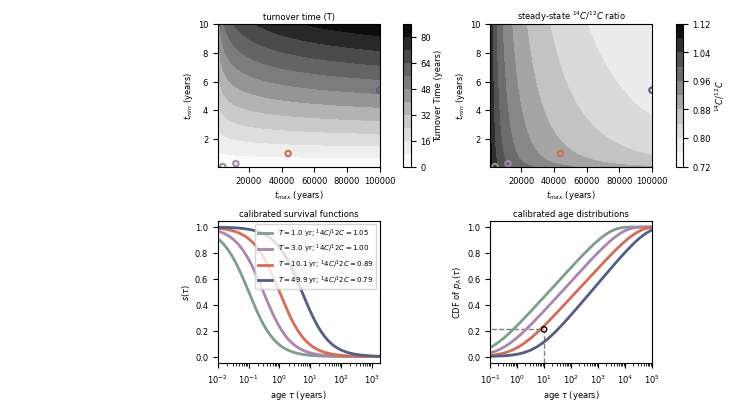

In [ ]:
mosaic = 'ABC\nDEF'
fig, axs = plt.subplot_mosaic(
    mosaic, layout='constrained', figsize=(7.25, 4))

# Panel A -- contour plot of turnover time with log-scaled axes
plt.sca(axs['B'])
plt.contourf(t_max_grid, t_min_grid, T_matrix,
             levels=10, cmap='Greys')
plt.colorbar(label='Turnover Time (years)')

# Mark the calibrated points
calibrated_colors = [colors[c] for c in ['dark_green', 'purple', 'red', 'dark_blue']]
for my_model, color in zip(calibrated_models, calibrated_colors):
    plt.scatter(my_model.t_max, my_model.t_min,
                marker='o', color='none',
                edgecolor=color, s=15, lw=1.5)

plt.xlabel('$t_{max}$ (years)')
plt.ylabel('$t_{min}$ (years)')
plt.title('turnover time (T)')

# Panel B -- contour plot of steady-state radiocarbon ratio
plt.sca(axs['C'])
plt.contourf(t_max_grid, t_min_grid, R_14C_matrix,
             levels=10, cmap='Greys')
plt.colorbar(label='$^{14}C / ^{12}C$')

# Mark the calibrated points
for my_model, color in zip(calibrated_models, calibrated_colors):
    plt.scatter(my_model.t_max, my_model.t_min,
                marker='o', color='none',
                edgecolor=color, s=15, lw=1.5)
plt.xlabel('$t_{max}$ (years)')
plt.ylabel('$t_{min}$ (years)')
plt.title(r'steady-state $^{14}C / ^{12}C$ ratio')

# Plot the survival functions for the calibrated points
plt.sca(axs['E'])
plt.xscale('log')
ages = np.logspace(-3, np.log10(1800), 200)
for i, (my_model, color) in enumerate(
    zip(calibrated_models, calibrated_colors)):
    survival_fn = my_model.survival_fn(ages)
    T_val = calibrated_Ts[i]
    R_14C_val = calibrated_R_14Cs[i]
    label=f'$T={T_val:.1f}$ yr; $^{14}C/^{12}C={R_14C_val:.2f}$'
    plt.plot(ages, survival_fn, color=color, lw=2, label=label)
plt.xlim(1e-2, 1800)
plt.xlabel(r'age $\tau$ (years)')
plt.ylabel(r'$s(\tau)$')
plt.title('calibrated survival functions')
#plt.legend(loc='upper right', fontsize=5)

plt.sca(axs['F'])
plt.xscale('log')
# plot the CDF of the age distributions for the calibrated points
for idx, (my_model, color) in enumerate(zip(calibrated_models, calibrated_colors)):
    # ages = np.arange(2000)
    ages = np.logspace(-3, np.log10(100000), 200)
    age_dist_cdf = my_model.age_distribution_cdf_analytic_ss(ages)
    plt.plot(ages, age_dist_cdf, color=color, lw=2)

# Diagram the process of model validation from a single point estimate
# of the CDF at age = 100 for example. 
obs_age, obs_CDF = 10, 0.21
plt.scatter([obs_age], [obs_CDF], color='none', 
            edgecolor='k', marker='o', s=15, lw=1,
            zorder=10)
# draw a dashed line to the x-axis from this point
plt.axvline(x=obs_age, ymin=0, ymax=obs_CDF,
            color='grey', linestyle='--', lw=1, zorder=-1)
ax = axs['F']
ax.hlines(y=obs_CDF, xmin=ax.get_xlim()[0], xmax=obs_age,
          colors='grey', linestyles='--', linewidth=1, zorder=-1)

plt.xlim(1e-1, 100000)
plt.xlabel(r'age $\tau$ (years)')
plt.ylabel(r'CDF of $p_A(\tau)$')
plt.title('calibrated age distributions')

# Turn off axes for panels A and D
axs['A'].axis('off')
axs['D'].axis('off')

plt.savefig('../figures/fig2_model_calibration.png', dpi=300, bbox_inches='tight')